# Factorial Multivariate Test For Conversion Rate on Credit Card Offers

[mahshidxyz](http://www.github.com/mahshidxyz)

July 2020

---

Factorial experiments are effective ways to explore the influence of several factors on the dependent variable. When every combination of factor levels is tested, we do not risk missing an optimal combination; however, with testing every level, experiments become large very quickly. To reduce the number of combinations we can do a two-level factorial experiment. These experiments are typically used for factor screening to identify the influential factors among many. Investigating two levels for each factor, we require $2^k$ experiments to test all the combinations. Another way to reduce the size of the experiment is using fractional factorial design. While a full factorial design includes all possible combinations of all levels across all the factors, a fractional factorial design includes only some combinations of factors. 
 

For this project I will work with the data of a full two-level factorial test. In this example, a credit card company ran a $2^4$ factorial experiment to test new ideas of improving conversion rates on credit card offers. $2^4$ combinations of these levels defined 16 credit card offers which were each sent to 7500 people. We need to find the influential factors on conversion, interpret the results, and select the best offer(s) among the 16 offers.

I will use a logistic regression model to identify the significant main effects and interaction. I will do a likelihood ratio test to compare the full and reduced models. Finally, I will use a chi-square test to select the best offers.

# The Experiment

A credit card company ran an experiment to investigate the influence of changing the factors including annual fee, account opening fee, initial interest rate, and long-term interest rate on the conversion rate of credit card offers. Each factor was investigated at two levels to create a total of $2^4$ credit card offers. Each offer was sent to 7500 people.

| Factor | | Low | High |
|:-|:-|:-|:-|
| Annual fee | $x_1$ | Current | Lower |
| Account opening fee | $x_2$ | No | Yes |
| Initial interest rate | $x_3$ | Current | Lower |
| Long-term interest rate | $x_4$ | Low | High |

## Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.factorplots as smfp
from scipy.stats import chi2_contingency
from scipy.stats.distributions import chi2
from statsmodels.stats.proportion import proportions_ztest


# set the rcParams globally, see the full list at plt.rcParams.keys() 
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['legend.title_fontsize'] = 'x-large'

In [2]:
# import the data
df = pd.read_csv("credit_card_marketing.csv")
df.head()

,Cond,x1,x2,x3,x4,y
0,1,-1,-1,-1,-1,0
1,1,-1,-1,-1,-1,0
2,1,-1,-1,-1,-1,0
3,1,-1,-1,-1,-1,0
4,1,-1,-1,-1,-1,0


In [3]:
# summarize the experiment
offers = df.groupby(['Cond', 'x1', 'x2', 'x3', 'x4'])['y'].agg({'sum','count'})
offers.rename(columns={'sum': 'n_accepted_offers', 'count': 'n_offers'}, inplace=True)
offers['conversion_pct'] = round(offers['n_accepted_offers']/offers['n_offers'] * 100, 2)
print ('Summary of the experiment:\nThe conversion rate varies between 1.69% to 3.39% between these 16 groups.')
offers = offers.sort_values(by='conversion_pct', ascending=False).reset_index()
offers

Summary of the experiment:
The conversion rate varies between 1.69% to 3.39% between these 16 groups.


,Cond,x1,x2,x3,x4,n_offers,n_accepted_offers,conversion_pct
0,6,1,-1,1,-1,7500,254,3.39
1,2,1,-1,-1,-1,7500,252,3.36
2,14,1,-1,1,1,7500,219,2.92
3,5,-1,-1,1,-1,7500,187,2.49
4,1,-1,-1,-1,-1,7500,184,2.45
5,8,1,1,1,-1,7500,183,2.44
6,7,-1,1,1,-1,7500,174,2.32
7,4,1,1,-1,-1,7500,172,2.29
8,13,-1,-1,1,1,7500,172,2.29
9,10,1,-1,-1,1,7500,168,2.24


# Logistic Regression

## Full logistic regression model

A full logistic regression model takes the following form:

\begin{equation*}
    logit(y) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 \\
    + \beta_{12}x_{12} + \beta_{13}x_{13} + \beta_{14}x_{14} + \beta_{23}x_{23} + \beta_{24}x_{24} + \beta_{34}x_{34} \\ + \beta_{123}x_{123} + \beta_{124}x_{124} + \beta_{234}x_{234} + \beta_{1234}x_{1234}
\end{equation*}

First the fit the full model to the data. Looking at the results we can see that:

- All main effects are significant
- Some of the two-factor interactions are significant
- All of the higher order interactions are insignificant

The results suggest that a reduced model with the following coefficients set to zero may be a good fit:

\begin{equation*}
    \beta_{13} = \beta_{14} = \beta_{23} = \beta_{123} = \beta_{124} = \beta_{134} = \beta_{234} = \beta_{1234} = 0
\end{equation*}

In [4]:
# full model: include all the interactions
model_full = sm.Logit.from_formula('y ~ x1 * x2 * x3 * x4', data = df).fit()
model_full.summary()

Optimization terminated successfully.
         Current function value: 0.111420
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               120000
Model:                          Logit   Df Residuals:                   119984
Method:                           MLE   Df Model:                           15
Date:                Sat, 08 Aug 2020   Pseudo R-squ.:                0.004214
Time:                        09:32:44   Log-Likelihood:                -13370.
converged:                       True   LL-Null:                       -13427.
Covariance Type:            nonrobust   LLR p-value:                 3.962e-17
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.7397      0.019   -193.337      0.000      -3.778      -3.702
x1              0.0808      0.019      4.180      0.000       0.043       0.119
x2             -0.1062      0.019     -5.491      0.000      -0.144      -0.068
x1:x2          -0.0552      0.019     -2.852      0.004      -0.093      -0.017
x3              0.0582      0.019      3.011      0.003       0.020       0.096
x1:x3          -0.0048      0.019     -0.248      0.804      -0.043       0.033
x2:x3          -0.0070      0.019     -0.360      0.719      -0.045       0.031
x1:x2:x3       -0.0096      0.019     -0.499      0.618      -0.048       0.028
x4             -0.1081      0.019     -5.588      0.000      -0.146      -0.070
x1:x4          -0.0132      0.019     -0.681      0.496      -0.051       0.025
x2:x4           0.0106      0.019      0.549      0.583      -0.027       0.049
x1:x2:x4        0.0106      0.019      0.549      0.583      -0.027       0.049
x3:x4           0.0381      0.019      1.969      0.049       0.000       0.076
x1:x3:x4       -0.0025      0.019     -0.131      0.895      -0.040       0.035
x2:x3:x4       -0.0209      0.019     -1.083      0.279      -0.059       0.017
x1:x2:x3:x4    -0.0095      0.019     -0.491      0.623      -0.047       0.028
===============================================================================
"""

## Reduced logistic regression model

In [5]:
# reduced model: only include the significant effects
model_reduced = sm.Logit.from_formula('y ~ x1 + x2 + x3 + x4 + x1:x2 + x3:x4', data = df).fit()
model_reduced.summary()

Optimization terminated successfully.
         Current function value: 0.111433
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               120000
Model:                          Logit   Df Residuals:                   119993
Method:                           MLE   Df Model:                            6
Date:                Sat, 08 Aug 2020   Pseudo R-squ.:                0.004105
Time:                        09:32:45   Log-Likelihood:                -13372.
converged:                       True   LL-Null:                       -13427.
Covariance Type:            nonrobust   LLR p-value:                 1.811e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7396      0.019   -193.306      0.000      -3.778      -3.702
x1             0.0821      0.019      4.279      0.000       0.045       0.120
x2            -0.1083      0.019     -5.644      0.000      -0.146      -0.071
x3             0.0589      0.019      3.072      0.002       0.021       0.096
x4            -0.1107      0.019     -5.777      0.000      -0.148      -0.073
x1:x2         -0.0571      0.019     -2.972      0.003      -0.095      -0.019
x3:x4          0.0405      0.019      2.114      0.034       0.003       0.078
==============================================================================
"""

## Likelihood ratio (deviance) test

To test whether several 𝛽’s are simultaneously zero, and hence to compare the full model to a reduced one, we use likelihood ratio test. The null hypothesis is that the reduced model is the best model and the alternative hypothesis is that the full model is the best one. The test statistic for the likelihood ratio (deviance) test (see [here](https://online.stat.psu.edu/stat504/node/220/) and [here](https://online.stat.psu.edu/stat462/node/207/)) is defined as

\begin{equation*}
    \Lambda = -2(log({\text{likelihood reduced model}})-log({\text{likelihood full model}}))
\end{equation*}

\begin{equation*}
    = 2log(\frac{\text{likelihood full model}}{\text{likelihood reduced model}})
\end{equation*}

If $H_0$ is true, the test statistic approximately follows a Chi-square distribution with k degrees of freedom, where k is number of predictors omitted in the reduced model.

\begin{equation*} P(X^2_{(k)} \ge \Lambda ) \end{equation*}

In our case $H_0: \beta_{13} = \beta_{14} = \beta_{23} = \beta_{123} = \beta_{124} = \beta_{134} = \beta_{234} = \beta_{1234} = 0$.

Our p-value is quite large so we cannot reject the null hypothesis and we conclude that the reduced model is appropriate. Now we can analyze the main effect and interaction effect plots for each of the significant effects.

In [6]:
print("Full model log-likelihood: {}".format(model_full.llf))
print("Reduced model log-likelihood: {}".format(model_reduced.llf))
dev = 2*(model_full.llf - model_reduced.llf)
print("Deviance is: {}".format(dev))
# chi-square test
# sf = survaival function, probability of chi2 > dev at df = 9 
p = chi2.sf(dev, 9)
print ('P-value:', p)

Full model log-likelihood: -13370.452476861828
Reduced model log-likelihood: -13371.914658646365
Deviance is: 2.9243635690727388
P-value: 0.9672182496399213


## Interpreting the results

The main effect plots suggest that increased conversion rates are associated with:

- Lower annual fees ($x_1$) 
- No account-opening fees ($x_2$)
- Lower initial interest rates ($x_3$)
- Lower long-term interest rates ($x_4$)

The interaction effect plots suggest:

- Low annual fees ($x_1$) are associated with high conversion rates when there is no account opening fee ($x_2$). However, if an account opening fee is charged, the annual fee will not be very influential.
- The initial interest rate ($x_3$) only becomes influential if the long-term interest rate ($x_4$) is low.

Note $x_1, x_3, x_4$ are continuous variables that are binarized for the purpose of this two-level factorial experiment and $x_2$ can be binary or continuous in real life. Therefore, interpreting the magnitude of the coefficients here will not be very meaningful.

### Main effects

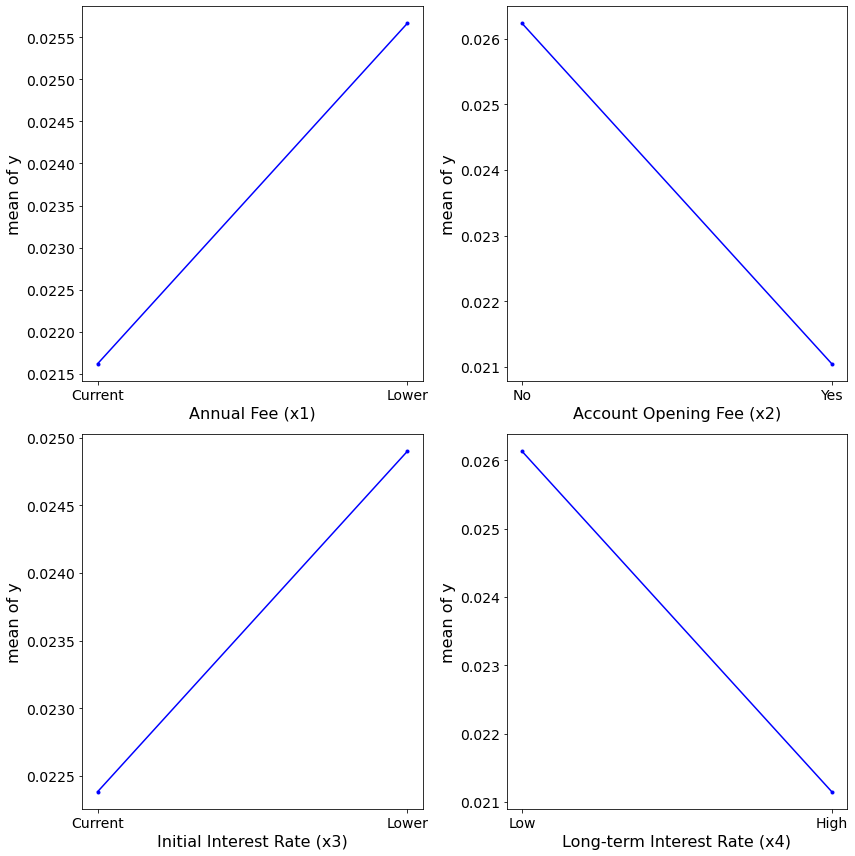

In [7]:
# main effect plots

fig, ax = plt.subplots(2,2, figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(df.groupby('x1')['y'].mean(), color = "blue", marker = ".")
plt.xlabel("Annual Fee (x1)")
plt.ylabel("mean of y")
plt.xticks([-1, 1], ['Current', 'Lower'])

plt.subplot(2,2,2)
plt.plot(df.groupby('x2')['y'].mean(), color = "blue", marker = ".")
plt.xlabel("Account Opening Fee (x2)")
plt.ylabel("mean of y")
plt.xticks([-1, 1], ['No', 'Yes'])

plt.subplot(2,2,3)
plt.plot(df.groupby('x3')['y'].mean(), color = "blue", marker = ".")
plt.xlabel("Initial Interest Rate (x3)")
plt.ylabel("mean of y")
plt.xticks([-1, 1], ['Current', 'Lower'])

plt.subplot(2,2,4)
plt.plot(df.groupby('x4')['y'].mean(), color = "blue", marker = ".")
plt.xlabel("Long-term Interest Rate (x4)")
plt.ylabel("mean of y")
plt.xticks([-1, 1], ['Low', 'High'])

plt.tight_layout()

### Interactions

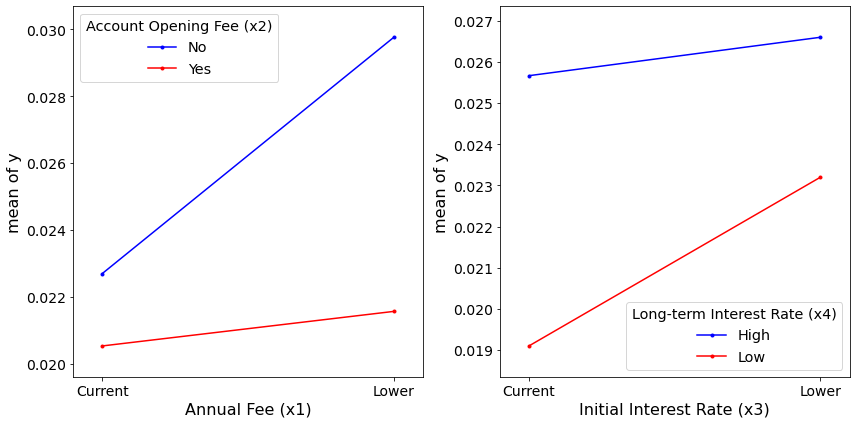

In [8]:
# interaction plots
fig, ax = plt.subplots(1,2, figsize=(12, 6))

_ = smfp.interaction_plot(x = df['x1'], trace = df['x2'], response = df['y'], colors = ['blue', 'red'], ax = ax[0])
ax[0].set_xlabel("Annual Fee (x1)")
ax[0].set_xticks([-1,1])
ax[0].set_xticklabels(['Current', 'Lower'])
ax[0].legend(['No', 'Yes'], title = "Account Opening Fee (x2)")

_ = smfp.interaction_plot(x = df['x3'], trace = df['x4'], response = df['y'], colors = ['blue', 'red'], ax = ax[1])
ax[1].set_xlabel("Initial Interest Rate (x3)")
ax[1].set_xticks([-1,1])
ax[1].set_xticklabels(['Current', 'Lower'])
ax[1].legend(['High', 'Low'], title = "Long-term Interest Rate (x4)")

## to get the order of legend labels
# ax[1].get_legend_handles_labels()

plt.tight_layout()

# Selecting the best offer(s)

The top two conversion rates are pretty close. We can use a chi-square test to compare the observed frequencies (converted and not converted) between the top offers. The results show that the difference between the top three offers' perfomances is not statistically significant. However, the forth best offer has a statistically significant lower performance. Therefore, I select the top three offers as the best offers.

In [9]:
# print the top offers
offers.head()

,Cond,x1,x2,x3,x4,n_offers,n_accepted_offers,conversion_pct
0,6,1,-1,1,-1,7500,254,3.39
1,2,1,-1,-1,-1,7500,252,3.36
2,14,1,-1,1,1,7500,219,2.92
3,5,-1,-1,1,-1,7500,187,2.49
4,1,-1,-1,-1,-1,7500,184,2.45


In [10]:
# total number of accepted offers for the potential best offers
first = offers['n_accepted_offers'][0]
second = offers['n_accepted_offers'][1]
third = offers['n_accepted_offers'][2]
forth = offers['n_accepted_offers'][3]

In [11]:
# chi-square test for top 3 offers: no significant difference between frequencies
chi2, p, dof, exp = chi2_contingency([[first, 7500 - first], [second, 7500 - second], [third, 7500-third]])
print("chi-square =", chi2, ", df =", dof, ", p-value =", p)

chi-square = 3.303693732926878 , df = 2 , p-value = 0.1916955454166999


In [12]:
# chi-square test for top 3 offers: there is a significant difference between frequencies
chi2, p, dof, exp = chi2_contingency([[first, 7500 - first], [second, 7500 - second], [third, 7500-third], [forth, 7500-forth]])
print("chi-square =", chi2, ", df =", dof, ", p-value =", p)

chi-square = 13.633764692258698 , df = 3 , p-value = 0.003448519530742739
